Primeiro, importa-se os módulos a serem usados.

In [180]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.naive_bayes import MultinomialNB as NaiveBayes
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

Importa-se também o dataset e o vemos.

In [98]:
wine = pd.read_csv("winequality.csv")
wine.head(10)

,Unnamed: 0,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_is_red
0,0,5.9,0.61,0.08,2.1,0.071,16.0,24.0,0.99376,3.56,0.77,11.1,6,1
1,1,8.2,1.00,0.09,2.3,0.065,7.0,37.0,0.99685,3.32,0.55,9.0,6,1
2,2,6.4,0.24,0.49,5.8,0.053,25.0,120.0,0.99420,3.01,0.98,10.5,6,0
3,3,6.6,0.23,0.26,1.3,0.045,16.0,128.0,0.99340,3.36,0.60,10.0,6,0
4,4,7.2,0.24,0.29,3.0,0.036,17.0,117.0,0.99411,3.36,0.68,10.1,6,0
5,5,7.1,0.26,0.32,5.9,0.037,39.0,97.0,0.99340,3.31,0.40,11.6,6,0
6,6,7.3,0.22,0.49,9.9,0.031,48.0,161.0,0.99370,3.01,0.28,11.2,6,0
7,7,7.3,0.32,0.34,6.6,0.032,24.0,112.0,0.99505,3.22,0.46,9.8,6,0
8,8,8.4,0.25,0.39,2.0,0.041,4.0,10.0,0.99386,3.27,0.71,12.5,7,1
9,9,6.7,0.75,0.01,2.4,0.078,17.0,32.0,0.99550,3.55,0.61,12.8,6,1


In [99]:
wine.tail(10)

,Unnamed: 0,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_is_red
6487,6487,7.2,0.630,0.00,1.9,0.097,14.0,38.0,0.99675,3.37,0.58,9.00,6,1
6488,6488,7.5,0.240,0.29,1.1,0.046,34.0,84.0,0.99020,3.04,0.39,11.45,6,0
6489,6489,6.8,0.410,0.30,8.8,0.045,28.0,131.0,0.99530,3.12,0.59,9.90,5,0
6490,6490,8.1,0.575,0.22,2.1,0.077,12.0,65.0,0.99670,3.29,0.51,9.20,5,1
6491,6491,7.5,0.270,0.34,2.3,0.050,4.0,8.0,0.99510,3.40,0.64,11.00,7,1
6492,6492,7.7,0.320,0.62,10.6,0.036,56.0,153.0,0.99780,3.13,0.44,8.90,6,0
6493,6493,6.2,0.220,0.28,2.2,0.040,24.0,125.0,0.99170,3.19,0.48,10.50,6,0
6494,6494,7.9,0.330,0.28,31.6,0.053,35.0,176.0,1.01030,3.15,0.38,8.80,6,0
6495,6495,7.0,0.300,0.28,2.2,0.042,21.0,177.0,0.99166,3.20,0.57,11.40,5,0
6496,6496,6.4,0.220,0.49,7.5,0.054,42.0,151.0,0.99480,3.27,0.52,10.10,6,0


Percebe-se que a coluna "Unnamed: 0" é apenas o index das samples e ,logo, desnecessária.

In [100]:
wine = wine.drop(columns = ["Unnamed: 0"])
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_is_red
0,5.9,0.61,0.08,2.1,0.071,16.0,24.0,0.99376,3.56,0.77,11.1,6,1
1,8.2,1.00,0.09,2.3,0.065,7.0,37.0,0.99685,3.32,0.55,9.0,6,1
2,6.4,0.24,0.49,5.8,0.053,25.0,120.0,0.99420,3.01,0.98,10.5,6,0
3,6.6,0.23,0.26,1.3,0.045,16.0,128.0,0.99340,3.36,0.60,10.0,6,0
4,7.2,0.24,0.29,3.0,0.036,17.0,117.0,0.99411,3.36,0.68,10.1,6,0


Observa-se a descriçao dos dados e percebe-se a necessidade de normalizar esse dataset.

In [101]:
print(f"O datasete possui {wine.shape[0]} samples e {wine.shape[1]} features.")
wine.describe()

O datasete possui 6497 samples e 13 features.


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_is_red
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378,0.246114
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255,0.430779
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000,0.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000,0.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000,0.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000,0.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000,1.000000


Assim, uma vez que o dataset possui apenas 13 features, nao há necessidade/obrigaçao de reduzi-lo.

E verifica-se se há valores faltantes.

In [102]:
wine.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
wine_is_red             0
dtype: int64

Nao há valores faltantes, porém há uma feature categórica ordinal(quality) e uma feature categórica nominal(wine_is_red) que deve-se se atentar quando realizando a normalizaçao, uma vez que está features nao apresentam explicitamente a "distancia" entre cada valor e por isso seria incabível normalizá-las.

E verifica-se também se há um desbalanceamento na quantidade de samples com as labels que desejamos prever. Assim, percebe-se que há( porém nao tao intenso) e que provavelmente nao há necessiade de lidar com isso a partir de uma combinaçao balanceada de métodos oversampling e undersampling.

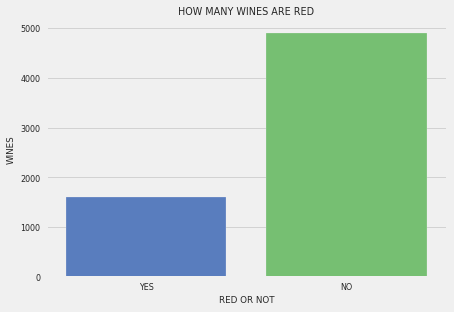

In [103]:
count_wine = wine.copy()
count_wine["wine_is_red"] = wine["wine_is_red"].replace([0,1],["NO","YES"])

plt.style.use("seaborn-muted")

sns.countplot(x = "wine_is_red", data = count_wine)
plt.title("HOW MANY WINES ARE RED")
plt.xlabel("RED OR NOT")
plt.ylabel("WINES")
plt.show()

Desse modo, primeiro normaliza-se o dataset de acordo com o que foi dito acima. Como "wine_is_red" é uma feature binária, normalizar por MinMax nao a modificará, logo só deve-se lidar com a feature ordinal "quality", que nao deve ser normalizada.

In [104]:
minmax = MinMaxScaler()
quality = wine["quality"]

wine = pd.DataFrame(minmax.fit_transform(wine), columns = wine.columns)
wine["quality"] = quality
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_is_red
0,0.173554,0.353333,0.048193,0.023006,0.102990,0.052083,0.041475,0.128205,0.651163,0.308989,0.449275,6,1.0
1,0.363636,0.613333,0.054217,0.026074,0.093023,0.020833,0.071429,0.187777,0.465116,0.185393,0.144928,6,1.0
2,0.214876,0.106667,0.295181,0.079755,0.073090,0.083333,0.262673,0.136688,0.224806,0.426966,0.362319,6,0.0
3,0.231405,0.100000,0.156627,0.010736,0.059801,0.052083,0.281106,0.121265,0.496124,0.213483,0.289855,6,0.0
4,0.280992,0.106667,0.174699,0.036810,0.044850,0.055556,0.255760,0.134953,0.496124,0.258427,0.304348,6,0.0


Agora, podemos aplicar alguns algoritmos para prever se o vinho é vermelho ou nao e sua qualidade e, entao, comparar suas performances.

In [150]:
y = wine["wine_is_red"].to_numpy()
X = wine.drop(columns = "wine_is_red").to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(f"O dataset de treinamento possui {X_train.shape[0]} samples e o de teste {X_test.shape[0]}.")

O dataset de treinamento possui 4547 samples e o de teste 1950.


# KNN

Antes de tudo, compilando a classe que eu fiz utilizando apenas Numpy que implementa o algoritmo KNN.

In [151]:
class KNN_handmade():
    def __init__(self, k):
        self.K = k
        self.x = None
        self.y = None
        self.list = []
        self.proba = None
    
    def fit(self, x, y):
        self.x = x
        self.y = y
        
    def predict(self, X_test):
        pred = []
        for x_test in X_test:
            euclidean_dist = np.sqrt(((self.x-x_test)**2).sum(axis = 1)) # getting the euclidean distance between the data points
            nearest_neighbours = np.argpartition(euclidean_dist, self.K)[:self.K]
            nearest_classifications = self.y[nearest_neighbours]
            labels, counts = np.unique(nearest_classifications, return_counts=True) # getting the probabilities of each classification close to the point
            self.proba = counts/counts.sum()
            pred.append(labels[self.proba.argmax()])
        return pred

E, logo, treinando modelos, um do sklearn e o outro meu, e entao medindo sua performance.

In [152]:
knn = KNN()
my_knn = KNN_handmade(5)


knn.fit(X_train, y_train)
my_knn.fit(X_train, y_train)

y_pred_sklearn = knn.predict(X_test)
y_pred_mine = my_knn.predict(X_test)

accuracy = accuracy_score(y_pred_sklearn,y_test)
precision = precision_score(y_pred_sklearn,y_test)
f1 = f1_score(y_pred_sklearn,y_test)

print("SKLEARN:")
print(f"A acurácia do modelo do sklearn foi de {accuracy*100: .5}%.")
print(f"A precisao do modelo do sklearn foi de {precision*100: .5}%.")
print(f"O f1-score do modelo do sklearn foi de {f1*100: .5}%. \n")

accuracy = accuracy_score(y_pred_mine,y_test)
precision = precision_score(y_pred_mine,y_test)
f1 = f1_score(y_pred_mine,y_test)

print("MEU:")
print(f"A acurácia do meu modelo foi de {accuracy*100: .5}%.")
print(f"A precisao do meu modelo foi de {precision*100: .5}%.")
print(f"O f1-score do meu modelo foi de {f1*100: .5}%.")

SKLEARN:
A acurácia do modelo do sklearn foi de  98.615%.
A precisao do modelo do sklearn foi de  96.875%.
O f1-score do modelo do sklearn foi de  97.35%. 

MEU:
A acurácia do meu modelo foi de  98.615%.
A precisao do meu modelo foi de  96.875%.
O f1-score do meu modelo foi de  97.35%.


A performance dos modelos é muito boa e nao houve diferenciaçao entre os modelos.

#PCA

Para buscar visualizar e representar o funcionamento de algoritmos como o Support Vector Machine, deve-se obter um dataset de no máximo 3 dimensoes - uma vez que nao há como visualizar a partir da 4-, logo a melhor maneira de reduzir o dataset de 13 para 2 dimensoes é por meio do PCA.

[]

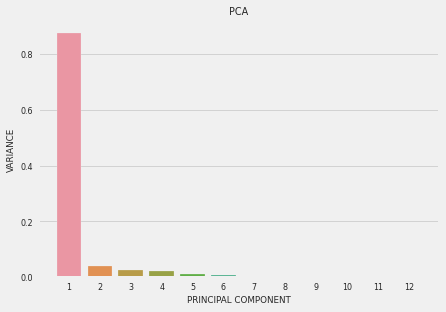

In [153]:
pca = PCA().fit(X)
variance = pca.explained_variance_ratio_

sns.barplot(x = np.arange(1,len(variance)+1),y = variance)
plt.title("PCA")
plt.xlabel("PRINCIPAL COMPONENT")
plt.ylabel("VARIANCE")
plt.plot()

Percebe-se facilmente que o PC1 detém mais de 80% da variancia/informaçao dos dados.

[]

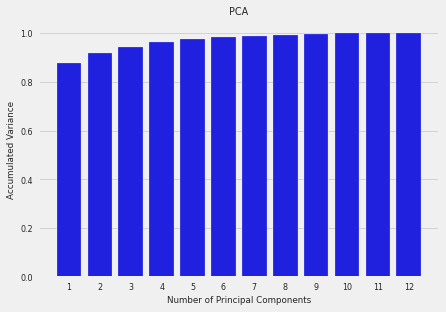

In [154]:
acc_variance = np.cumsum(variance)

sns.barplot(x = np.arange(1,len(acc_variance)+1),y = acc_variance, color = "blue")
plt.title("PCA")
plt.xlabel("Number of Principal Components")
plt.ylabel("Accumulated Variance")
plt.plot()

E, logo, PC1 e PC2, detém mais de 90% da variancia/informaçao dos dados. Dessa maneira, aplicar os algoritmos baseado nessa transformaçao de dados resultará em um ótima performance assimilando-se a perfomance do dataset com 3 features, porém com apenas duas.

Assim, pode-se visualizar os dados após a transformaçao e reduçao.

[]

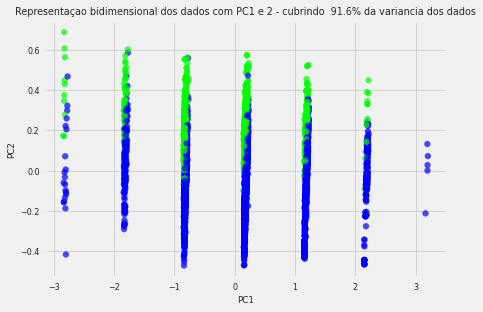

In [155]:
X_pca = pca.fit_transform(X)

sns.scatterplot(x = X_pca[:, 0],y = X_pca[:, 1],c = y,edgecolor = 'none',alpha = 0.7,s = 40,cmap = plt.cm.get_cmap('brg', 10))
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"Representaçao bidimensional dos dados com PC1 e 2 - cubrindo {acc_variance[1]*100: .3}% da variancia dos dados")
plt.plot()

In [156]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca[:,0:2], y, test_size = 0.3)
print(X_train_pca.shape)

(4547, 2)


# Support Vector Machine

Agora, treinaremos modelos com os 4 kernels disponivéis e observaremos suas performances.

In [157]:
for kernel in ["linear", "poly", "rbf", "sigmoid"] :
  svc = SVC(kernel = kernel)
  svc.fit(X_train, y_train)

  y_pred_svm = svc.predict(X_test)

  accuracy = accuracy_score(y_pred_svm,y_test)
  precision = precision_score(y_pred_svm,y_test)
  f1 = f1_score(y_pred_svm,y_test)

  print(f"USANDO O KERNEL {kernel.upper()}:")
  print(f"A acurácia do modelo do sklearn foi de {accuracy*100: .5}%.")
  print(f"A precisao do modelo do sklearn foi de {precision*100: .5}%.")
  print(f"O f1-score do modelo do sklearn foi de {f1*100: .5}%. \n")


USANDO O KERNEL LINEAR:
A acurácia do modelo do sklearn foi de  98.821%.
A precisao do modelo do sklearn foi de  97.656%.
O f1-score do modelo do sklearn foi de  97.752%. 

USANDO O KERNEL POLY:
A acurácia do modelo do sklearn foi de  98.513%.
A precisao do modelo do sklearn foi de  95.508%.
O f1-score do modelo do sklearn foi de  97.12%. 

USANDO O KERNEL RBF:
A acurácia do modelo do sklearn foi de  98.513%.
A precisao do modelo do sklearn foi de  95.508%.
O f1-score do modelo do sklearn foi de  97.12%. 

USANDO O KERNEL SIGMOID:
A acurácia do modelo do sklearn foi de  67.333%.
A precisao do modelo do sklearn foi de  31.641%.
O f1-score do modelo do sklearn foi de  33.715%. 



E, analogamente, veremos a performance com o dataset reduzido por PCA.

In [158]:
for kernel in ["linear", "poly", "rbf", "sigmoid"]:
  svc = SVC(kernel = kernel)

  svc.fit(X_train_pca, y_train_pca)

  y_pred_svm = svc.predict(X_test_pca)

  accuracy = accuracy_score(y_pred_svm,y_test_pca)
  precision = precision_score(y_pred_svm,y_test_pca)
  f1 = f1_score(y_pred_svm,y_test_pca)

  print(f"USANDO O KERNEL {kernel.upper()}:")
  print(f"A acurácia do modelo do sklearn foi de {accuracy*100: .5}%.") 
  print(f"A precisao do modelo do sklearn foi de {precision*100: .5}%.")
  print(f"O f1-score do modelo do sklearn foi de {f1*100: .5}%. \n")

USANDO O KERNEL LINEAR:
A acurácia do modelo do sklearn foi de  86.564%.
A precisao do modelo do sklearn foi de  63.561%.
O f1-score do modelo do sklearn foi de  70.091%. 

USANDO O KERNEL POLY:
A acurácia do modelo do sklearn foi de  77.231%.
A precisao do modelo do sklearn foi de  9.5238%.
O f1-score do modelo do sklearn foi de  17.164%. 

USANDO O KERNEL RBF:
A acurácia do modelo do sklearn foi de  87.231%.
A precisao do modelo do sklearn foi de  62.733%.
O f1-score do modelo do sklearn foi de  70.877%. 

USANDO O KERNEL SIGMOID:
A acurácia do modelo do sklearn foi de  79.487%.
A precisao do modelo do sklearn foi de  57.971%.
O f1-score do modelo do sklearn foi de  58.333%. 



Percebe-se uma performance boa, porém nao tanto como a com o dataset nao-reduzido. Entretanto, se usassemos mais uma feature do dataset transformado por PCA, já obteríamos performances praticamente iguais.

Além disso, o intuito do uso do PCA é para que possamos visualizar o hiperplano que separa os dados. Abaixo em seguida, está a funçao que será utilizada para isso.

In [159]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=1,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=5, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

Para o kernel linear:

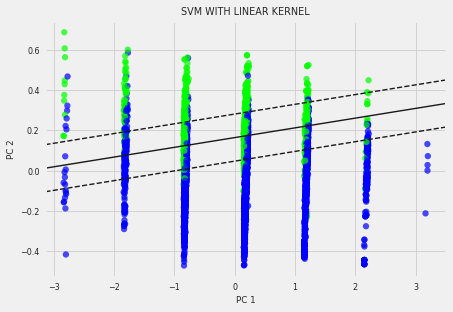

In [160]:
svc = SVC(kernel = "linear")
svc.fit(X_train_pca, y_train_pca)

sns.scatterplot(x = X_pca[:, 0],y = X_pca[:, 1],c = y,edgecolor = 'none',alpha = 0.7,s = 40,cmap = plt.cm.get_cmap('brg', 10))
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("SVM WITH LINEAR KERNEL")
plot_svc_decision_function(svc)

Para o kernel "RBF":

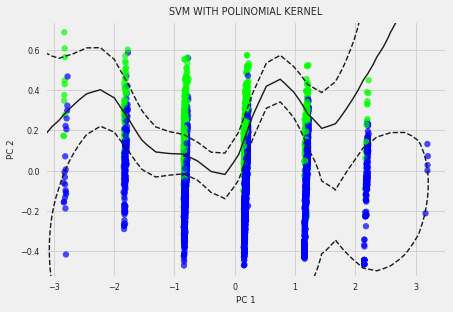

In [161]:
svc = SVC(kernel = "rbf")
svc.fit(X_train_pca, y_train_pca)

sns.scatterplot(x = X_pca[:, 0],y = X_pca[:, 1],c = y,edgecolor = 'none',alpha = 0.7,s = 40,cmap = plt.cm.get_cmap('brg', 10))
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("SVM WITH POLINOMIAL KERNEL")
plot_svc_decision_function(svc)

# DecisionTree


Agora, treinaremos uma árvore de decisao e as visualizaremos.

In [162]:
dtree = tree.DecisionTreeClassifier()

dtree.fit(X_train, y_train)

y_pred_dtree = dtree.predict(X_test)

accuracy = accuracy_score(y_pred_dtree,y_test)
precision = precision_score(y_pred_dtree,y_test)
f1 = f1_score(y_pred_dtree,y_test)

print(f"A acurácia do modelo do sklearn foi de {accuracy*100: .5}%.") 
print(f"A precisao do modelo do sklearn foi de {precision*100: .5}%.")
print(f"O f1-score do modelo do sklearn foi de {f1*100: .5}%. \n")

A acurácia do modelo do sklearn foi de  97.846%.
A precisao do modelo do sklearn foi de  96.484%.
O f1-score do modelo do sklearn foi de  95.922%. 



O modelo apresentou também performance bem alta.

Porém, diante de sua dimensao o entendimento é bastante complicado.

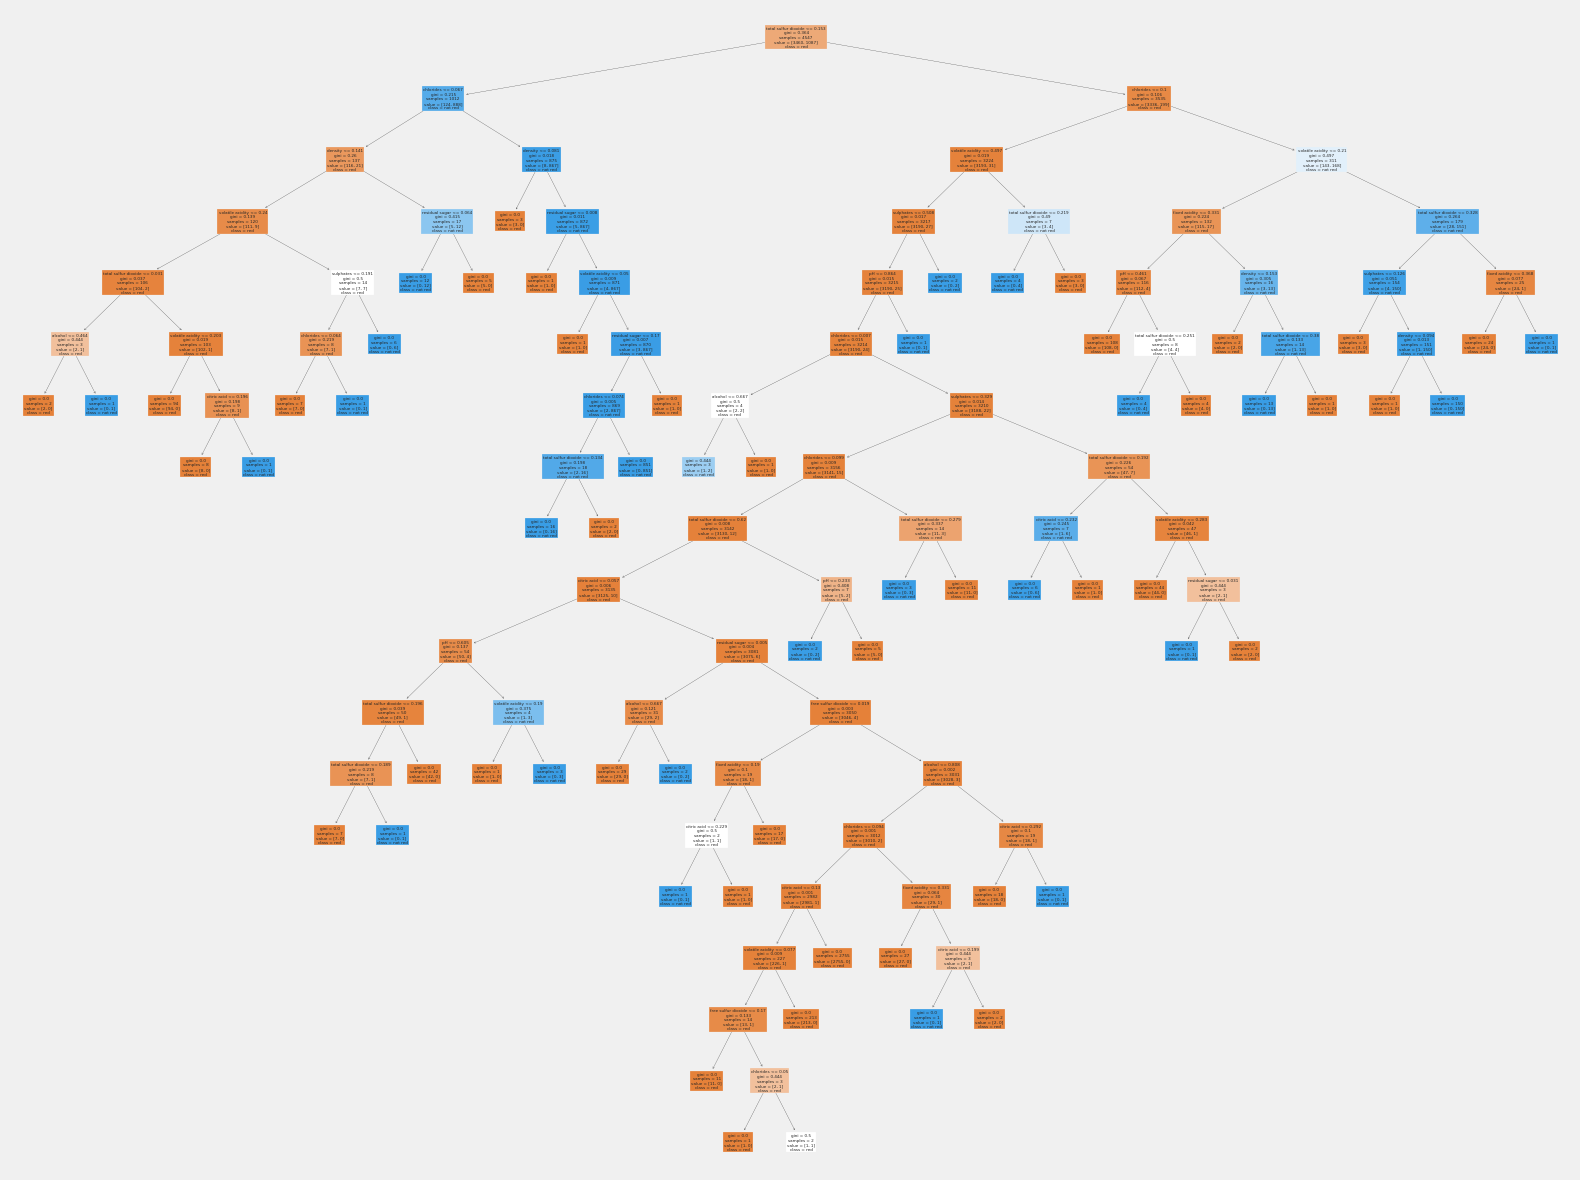

In [163]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dtree, feature_names=wine.columns[:-1],  class_names=["red","not red"],filled=True)

# Random Forest

Agora, treinaremos e mediremos a perfomance de um modelo de Random Forest.

In [164]:
randomf = RandomForestClassifier()

randomf.fit(X_train, y_train)

y_pred_rf = randomf.predict(X_test)

accuracy = accuracy_score(y_pred_rf,y_test)
precision = precision_score(y_pred_rf,y_test)
f1 = f1_score(y_pred_rf,y_test)

print(f"A acurácia do modelo do sklearn foi de {accuracy*100: .5}%.") 
print(f"A precisao do modelo do sklearn foi de {precision*100: .5}%.")
print(f"O f1-score do modelo do sklearn foi de {f1*100: .5}%. \n")

A acurácia do modelo do sklearn foi de  99.282%.
A precisao do modelo do sklearn foi de  97.852%.
O f1-score do modelo do sklearn foi de  98.622%. 



Mais uma vez, o modelo apresentou performance elevada e também levemente melhor do que o modelo de Decision Tree, como esperado.

# Multiclass classification

Agora, veremos e treinaremos os modelos para ver a qualidade do vinho ao invés de sua cor.

In [166]:
y = wine["quality"].to_numpy()
X = wine.drop(columns = ["quality"]).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
print(f"O dataset de treinamento possui {X_train.shape[0]} samples e o de teste {X_test.shape[0]}.")

O dataset de treinamento possui 4547 samples e o de teste 1950.


Primeiramente, treinando-se um modelo de KNN.

SKLEARN:
A acurácia do modelo do sklearn foi de  55.487%.
A precisao do modelo do sklearn foi de  59.575%.
O f1-score do modelo do sklearn foi de  57.108%. 

MEU:
A acurácia do meu modelo foi de  55.487%.
A precisao do meu modelo foi de  59.575%.
O f1-score do meu modelo foi de  57.108%.


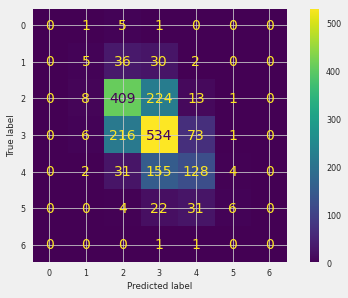

In [167]:
knn = KNN()
my_knn = KNN_handmade(5)


knn.fit(X_train, y_train)
my_knn.fit(X_train, y_train)

y_pred_sklearn = knn.predict(X_test)
y_pred_mine = my_knn.predict(X_test)

accuracy = accuracy_score(y_pred_sklearn, y_test)
precision = precision_score(y_pred_sklearn, y_test, average = "weighted")
f1 = f1_score(y_pred_sklearn, y_test, average = "weighted")

print("SKLEARN:")
print(f"A acurácia do modelo do sklearn foi de {accuracy*100: .5}%.")
print(f"A precisao do modelo do sklearn foi de {precision*100: .5}%.")
print(f"O f1-score do modelo do sklearn foi de {f1*100: .5}%. \n")

accuracy = accuracy_score(y_pred_mine, y_test)
precision = precision_score(y_pred_mine, y_test, average = "weighted")
f1 = f1_score(y_pred_mine, y_test, average = "weighted")

print("MEU:")
print(f"A acurácia do meu modelo foi de {accuracy*100: .5}%.")
print(f"A precisao do meu modelo foi de {precision*100: .5}%.")
print(f"O f1-score do meu modelo foi de {f1*100: .5}%.")

c_matrix = confusion_matrix(y_test, y_pred_mine)
ConfusionMatrixDisplay(confusion_matrix = c_matrix).plot()

Percebe-se que o modelo apresentou performance bem baixa.

Agora, treinaremos modelos de SVM com os diferentes kernels.

In [168]:
for kernel in ["linear", "poly", "rbf", "sigmoid"] :
  svc = SVC(kernel = kernel)
  svc.fit(X_train, y_train)

  y_pred_svm = svc.predict(X_test)

  accuracy = accuracy_score(y_pred_svm,y_test)
  precision = precision_score(y_pred_svm,y_test, average = "weighted")
  f1 = f1_score(y_pred_svm,y_test, average = "weighted")

  print(f"USANDO O KERNEL {kernel.upper()}:")
  print(f"A acurácia do modelo do sklearn foi de {accuracy*100: .5}%.")
  print(f"A precisao do modelo do sklearn foi de {precision*100: .5}%.")
  print(f"O f1-score do modelo do sklearn foi de {f1*100: .5}%. \n")

USANDO O KERNEL LINEAR:
A acurácia do modelo do sklearn foi de  52.0%.
A precisao do modelo do sklearn foi de  70.205%.
O f1-score do modelo do sklearn foi de  59.097%. 

USANDO O KERNEL POLY:
A acurácia do modelo do sklearn foi de  52.41%.
A precisao do modelo do sklearn foi de  66.555%.
O f1-score do modelo do sklearn foi de  56.919%. 

USANDO O KERNEL RBF:
A acurácia do modelo do sklearn foi de  54.051%.
A precisao do modelo do sklearn foi de  67.857%.
O f1-score do modelo do sklearn foi de  58.884%. 

USANDO O KERNEL SIGMOID:
A acurácia do modelo do sklearn foi de  35.282%.
A precisao do modelo do sklearn foi de  36.432%.
O f1-score do modelo do sklearn foi de  35.679%. 



E, observa-se, novamente um desempenho ruim.

Agora, treinaremos um modelo de Decision Tree.

In [169]:
dtree = tree.DecisionTreeClassifier()

dtree.fit(X_train, y_train)

y_pred_dtree = dtree.predict(X_test)

accuracy = accuracy_score(y_pred_dtree, y_test)
precision = precision_score(y_pred_dtree, y_test, average = "weighted")
f1 = f1_score(y_pred_dtree, y_test, average = "weighted")

print(f"A acurácia do modelo do sklearn foi de {accuracy*100: .5}%.") 
print(f"A precisao do modelo do sklearn foi de {precision*100: .5}%.")
print(f"O f1-score do modelo do sklearn foi de {f1*100: .5}%. \n")

A acurácia do modelo do sklearn foi de  57.282%.
A precisao do modelo do sklearn foi de  57.396%.
O f1-score do modelo do sklearn foi de  57.312%. 



E, chega-se novamente a uma performance ruim.

Treina-se agora um modelo de Random Forest.

In [170]:
randomf = RandomForestClassifier()

randomf.fit(X_train, y_train)

y_pred_rf = randomf.predict(X_test)

accuracy = accuracy_score(y_pred_rf, y_test)
precision = precision_score(y_pred_rf, y_test, average = "weighted")
f1 = f1_score(y_pred_rf, y_test, average = "weighted")

print(f"A acurácia do modelo do sklearn foi de {accuracy*100: .5}%.") 
print(f"A precisao do modelo do sklearn foi de {precision*100: .5}%.")
print(f"O f1-score do modelo do sklearn foi de {f1*100: .5}%. \n")

A acurácia do modelo do sklearn foi de  66.0%.
A precisao do modelo do sklearn foi de  70.973%.
O f1-score do modelo do sklearn foi de  67.375%. 



Por tratar-se já de um modelo de ensemble learning( aplicando esta técnica - com Bagging e Boosting - a modelos de Decision Tree), chega-se a um desempenho razoavelmente melhor que os demais.

Pode-se também aplicar o conceito de bagging aos modelos já treinados e chegar a um modelo um pouco melhor ( só nao é melhor que Random Forest, porque Random Forest, por ser um algoritmo de ensemble learning, apresenta técnicas como boosting e tracking, além de baggin).

In [195]:
y_pred_bagging = []
for y in zip(y_pred_sklearn, y_pred_mine, y_pred_rf, y_pred_svm, y_pred_dtree):
  y_pred_bagging.append(np.bincount(np.asarray(y)).argmax())

accuracy = accuracy_score(y_pred_bagging, y_test)
precision = precision_score(y_pred_bagging, y_test, average = "weighted")
f1 = f1_score(y_pred_bagging, y_test, average = "weighted")

print(f"A acurácia do modelo do sklearn foi de {accuracy*100: .5}%.") 
print(f"A precisao do modelo do sklearn foi de {precision*100: .5}%.")
print(f"O f1-score do modelo do sklearn foi de {f1*100: .5}%. \n")

A acurácia do modelo do sklearn foi de  59.077%.
A precisao do modelo do sklearn foi de  64.479%.
O f1-score do modelo do sklearn foi de  61.109%. 

